In [2]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, \
NthOrderBoundaryCondition, ExplicitDiffusionTerm, TransientTerm, DiffusionTerm, Viewer,PowerLawConvectionTerm,ImplicitSourceTerm
from fipy.tools import numerix
from fipy import DefaultSolver
import numpy as np
import math
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
L = 3.
T = 1.
nx = 2000
nt = 2000
dx = L/nx
mesh = Grid1D(nx=nx, dx=dx)

valueLeft = 1
valueRight = 0
timeStepDuration = T/nt
steps = nt

In [4]:
def solution(x,t,L,n_max):
    V = t/L + L/3
    for n in range(1,n_max+1):
        V+=-2*L/(math.pi**2*n**2)*torch.exp(-math.pi**2*n**2*t/L**2)*torch.cos(math.pi*n*x/L)
    return -2 + 2*torch.sqrt(-x + x**2/(2*L) + 1 + V)
def pc(u):
    return torch.full_like(u,1) + 0.5*u
def K_(u):
    return torch.full_like(u,1) + 0.5*u
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # производная по времени
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # вторая производная по x
    K = K_(u)
    du_x = dde.grad.jacobian(u,x,i=0,j=0)
    dK_u = dde.grad.jacobian(K,u, i = 0, j = 0)
    
    return du_t - (K * du_xx + dK_u*(du_x)**2)/pc(u)
def pde(x, u):
    u_t = dde.grad.jacobian(u, x, i=0, j=1)
    u_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    numerator = u_xx * (1 + u/2) + (u_x * u_x) / 2
    return u_t - numerator / (1 + u/2)
def boundary_left(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and not np.isclose(x[1],0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1],0)

def boundary_left_0(x, on_boundary):
    
    return on_boundary and np.isclose(x[0], 0) and np.isclose(x[1],0)
def boundary_right_0(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and np.isclose(x[1],0)

def right_condition(x, u, _):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return -K_(u)*grad 
def left_condition(x,u,_):
    grad = dde.grad.jacobian(u, x, i = 0, j = 0)

    return -K_(u)*grad - 1


In [5]:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc_right = dde.OperatorBC(geomtime, right_condition, boundary_right)
bc_left = dde.OperatorBC(geomtime, left_condition, boundary_left)

ic = dde.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right,ic],
    num_domain=2000,  # точек внутри области
    num_boundary=200, # точек на границе
    num_initial=200,  # точек для начального условия
    
)
net = dde.nn.FNN(
    [2] + [100] * 2 + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
    "tanh",
    "Glorot normal",
)
# Модель и обучение
model = dde.Model(data, net)
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох

model.compile("adam", lr=1e-4, loss=torch.nn.MSELoss(reduction='sum'), loss_weights=[1,1,1,100])
model.train(iterations=8000,callbacks=[resampler])
model.compile('L-BFGS', loss = torch.nn.MSELoss(reduction='sum'), loss_weights= [1,1,1,100])
losshistory, train_state = model.train()

Compiling model...
'compile' took 1.245962 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.31e+00, 6.37e+01, 9.00e-01, 1.82e+03]    [8.31e+00, 6.37e+01, 9.00e-01, 1.82e+03]    []  
1000      [9.36e-02, 8.85e+01, 1.19e-01, 2.08e+00]    [9.17e-02, 8.85e+01, 1.19e-01, 2.08e+00]    []  
2000      [4.62e-01, 8.08e+01, 2.16e-01, 5.43e+00]    [4.48e-01, 8.08e+01, 2.16e-01, 5.43e+00]    []  
3000      [2.57e+00, 5.45e+01, 9.35e-03, 7.53e+00]    [2.49e+00, 5.45e+01, 9.35e-03, 7.53e+00]    []  
4000      [2.99e+00, 8.89e+00, 4.62e-02, 5.11e+00]    [2.94e+00, 8.89e+00, 4.62e-02, 5.11e+00]    []  
5000      [1.48e+00, 5.28e+00, 2.46e-02, 3.28e+00]    [1.47e+00, 5.28e+00, 2.46e-02, 3.28e+00]    []  
6000      [7.14e-01, 4.03e+00, 5.69e-03, 2.00e+00]    [7.17e-01, 4.03e+00, 5.69e-03, 2.00e+00]    []  
7000      [6.09e-01, 3.38e+00, 1.60e-02, 1.49e+00]    [6.11e-01, 3.38e+00, 1.60e-02, 1.49e+00]    []  
8

In [6]:
phi = CellVariable(name="solution variable",
                   mesh=mesh,
                   value=0.)

def K_(u):
    return np.full_like(u,1) + 0.5*u
phi.faceGrad.constrain(-1/K_(phi.faceValue),where=mesh.facesLeft)
phi.faceGrad.constrain(0, where= mesh.facesRight)


eqX = (TransientTerm(coeff = 1)
      == DiffusionTerm(coeff=K_(phi)) )
x = mesh.cellCenters[0]



from builtins import range
solver = DefaultSolver()


In [7]:
U_exact = []
def solution(x,t,L,n_max):
    V = t/L + L/3
    for n in range(1,n_max+1):
        V+=-2*L/(math.pi**2*n**2)*np.exp(-math.pi**2*n**2*t/L**2)*np.cos(math.pi*n*x/L)
    return -2 + 2*np.sqrt(-x + x**2/(2*L) + 1 + V)


for step in range(steps):
    npx = torch.from_numpy(np.array(x))
    
    U_exact.append(solution(npx,timeStepDuration*step,L,10))
    

/tmp/ipykernel_12980/1662323356.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  V+=-2*L/(math.pi**2*n**2)*np.exp(-math.pi**2*n**2*t/L**2)*np.cos(math.pi*n*x/L)
/tmp/ipykernel_12980/1662323356.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return -2 + 2*np.sqrt(-x + x**2/(2*L) + 1 + V)


In [8]:

U_pinn = []
U_fem = []

def solution(x,t,L,n_max):
    V = t/L + L/3
    for n in range(1,n_max+1):
        V+=-2*L/(math.pi**2*n**2)*np.exp(-math.pi**2*n**2*t/L**2)*np.cos(math.pi*n*x/L)
    return -2 + 2*np.sqrt(-x + x**2/(2*L) + 1 + V)


for step in range(steps):
    npx = torch.from_numpy(np.array(x))
    
    
    U_fem.append(np.array(phi))
    
    U_pinn.append(model.predict(torch.vstack([npx, torch.full_like(npx,timeStepDuration*step)]).T).ravel())

    eqX.solve(var=phi,
              dt=timeStepDuration,
              #boundaryConditions = BCs,
              solver = solver)


In [9]:
U_exact = np.array(U_exact)

U_fem = np.array(U_fem)
U_pinn = np.array(U_pinn)

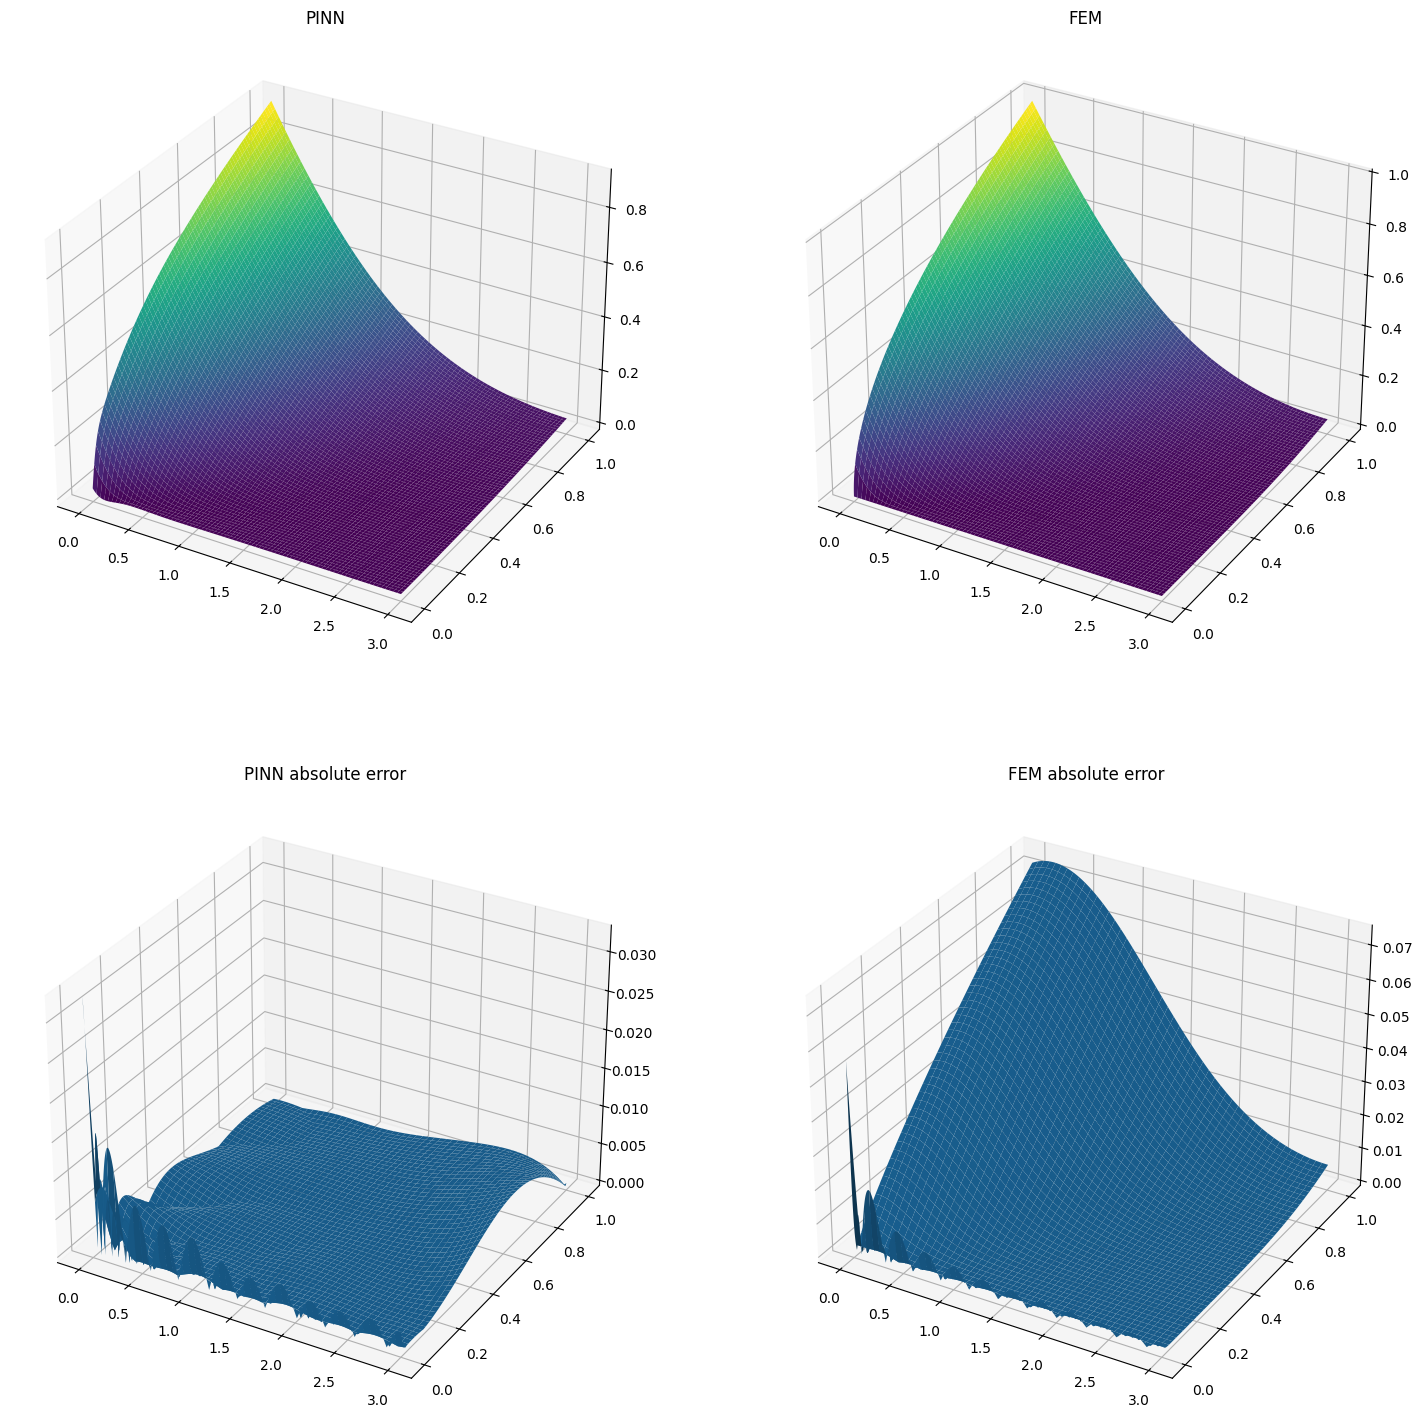

In [14]:

import matplotlib.pyplot as plt
Ts = np.linspace(0,T,nt)
Xs = np.linspace(0,L,nx)
XX,TT = np.meshgrid(Xs,Ts)
fig = plt.figure(figsize=(18,18))
ax = fig.add_subplot(2,2,1, projection = '3d')
ax.plot_surface(XX,TT,U_pinn,rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title('PINN')
ax = fig.add_subplot(2,2,2, projection = '3d')
ax.plot_surface(XX,TT,U_fem,rcount=80, ccount=80, cmap="viridis", edgecolor="none")
ax.set_title('FEM')
ax = fig.add_subplot(2,2,3, projection = '3d')
ax.set_title('PINN absolute error')
ax.plot_surface(XX,TT,np.abs(U_pinn - U_exact))
ax = fig.add_subplot(2,2,4, projection = '3d')
ax.set_title('FEM absolute error')
ax.plot_surface(XX,TT,np.abs(U_fem - U_exact))


In [15]:
print('PINN L2 -', np.mean(np.sqrt(np.mean((U_pinn - U_exact)**2,axis = 1))))
print('PINN MAX ERR -', np.max((np.abs((U_pinn - U_exact)))))

print('FEM L2 -', np.mean(np.sqrt(np.mean((U_fem - U_exact)**2,axis = 1))))
print('PINN MAX ERR -', np.max((np.abs((U_fem - U_exact)))))



PINN L2 - 0.00147701633503615
PINN MAX ERR - 0.03266158593430468
FEM L2 - 0.0215763642893143
PINN MAX ERR - 0.0741251780932014
